In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import torch
from umap import UMAP

import pancancer_evaluation.config as cfg
from csd_simulations import simulate_csd
from fit_models import fit_k_folds_csd

np.random.seed(42)
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

### Simulate data from multiple "domains"

Main simulation code is in `09_simulations/csd_simulations.py`.

In [2]:
# see 09_simulations/csd_simulations.py for details on simulation parameters
n_domains = 5
n_per_domain = 50
p = 20
k = 5
k_sim_range = [1, 2, 3, 5, 10]
k_model_range = [1, 2, 3, 5, 10]

corr_top, diag = 1, None

# location to save plots to
output_plots = True
sim_results_dir = cfg.repo_root / '09_simulations' / 'simulation_results' / 'simulate_k'
output_plots_dir = cfg.repo_root / '09_simulations' / 'simulation_plots' / 'simulate_k'

In [3]:
xs, ys = simulate_csd(n_domains, n_per_domain, p, k, 
                      corr_noise=True,
                      corr_top=corr_top,
                      diag=diag)
domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

print(xs.shape)
print(xs[:5, :5])

(125, 20)
[[ 1.84023368 -3.59690101  0.29815664 -4.57198419  0.8939916 ]
 [-0.31444919  1.24656857 -1.3437388  -0.87838585 -2.39541086]
 [ 0.26753875 -4.25080318 -0.23958198 -3.55497219 -3.92958233]
 [-1.0974214  -3.10565759 -1.50897959 -3.40290593 -3.25123423]
 [ 1.79573188 -4.06134746  0.01405683 -1.21646615 -3.270836  ]]


In [4]:
print(ys.shape)
print(ys[:3, :])

(125, 1)
[[ 1]
 [ 1]
 [-1]]


In [5]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,13.637556,4.475949,0,1
1,13.266127,5.340850,0,1
2,13.564172,6.179660,0,-1
3,13.866877,5.907993,0,-1
4,13.973321,5.586529,0,-1


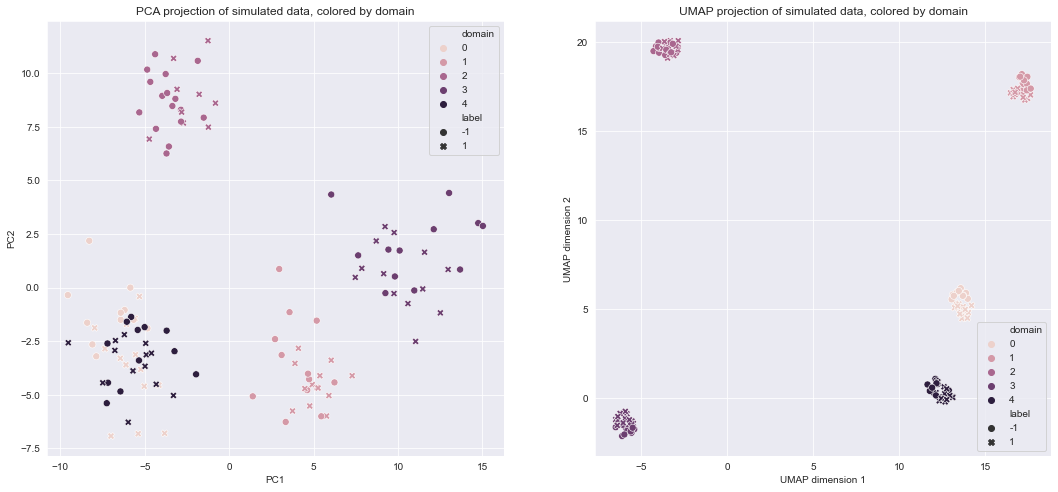

In [6]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[0].set_xlabel('PC1')
axarr[0].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(
        output_plots_dir / 'n{}_p{}_k{}_corr{}_scale{}_pca_umap.png'.format(
            n_domains, p, k, corr_top, diag),
    dpi=200, bbox_inches='tight')

### Fit models with varying (fixed) k

Here, we'll fix a k (latent space dimension) value for the simulated data, and try several different values for the model. We'd expect the model to find the true value or something close to it.

In [7]:
results_df = fit_k_folds_csd(
    xs, ys, domains[:, np.newaxis], k_model_range
)
results_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,k_model,fold,metric,value
0,1,0,train_auroc,0.851628
1,2,0,train_auroc,0.950233
2,3,0,train_auroc,0.951628
3,5,0,train_auroc,0.919535
4,10,0,train_auroc,0.938140


(-0.1, 1.1)

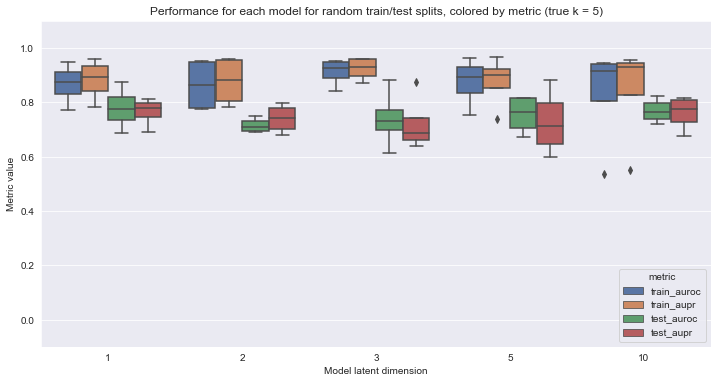

In [8]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(
    data=results_df.sort_values(by=['k_model'])
                   .sort_values(by=['metric'], ascending=False),
    x='k_model', y='value', hue='metric'
)
plt.title(
    'Performance for each model for random train/test splits, colored by metric (true k = {})'
    .format(k)
)
plt.xlabel('Model latent dimension')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

In [9]:
# hold out domain that was generated last; use all other domains for training
def get_holdout_split(xs, ys, domains):
    holdout_domain = np.unique(domains)[-1]
    X_train = xs[domains != holdout_domain, :]
    X_holdout = xs[domains == holdout_domain, :]
    y_train = ys[domains != holdout_domain, :]
    y_holdout = ys[domains == holdout_domain, :]
    ds_train = domains[domains != holdout_domain, np.newaxis]
    ds_holdout = domains[domains == holdout_domain, np.newaxis]
    return (X_train, X_holdout, y_train, y_holdout, ds_train, ds_holdout)

In [10]:
holdout_split = get_holdout_split(xs, ys, domains)
(X_train,
 X_holdout,
 y_train,
 y_holdout,
 ds_train,
 ds_holdout) = holdout_split

results_df = fit_csd_k_range(
    X_holdout, y_holdout, ds_holdout, k_model_range,
    train_data=(X_train, y_train, ds_train)
)
results_df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,k_model,fold,metric,value
0,1,0,train_auroc,0.948780
1,2,0,train_auroc,0.963185
2,3,0,train_auroc,0.969988
3,5,0,train_auroc,0.955582
4,10,0,train_auroc,0.962385


(-0.1, 1.1)

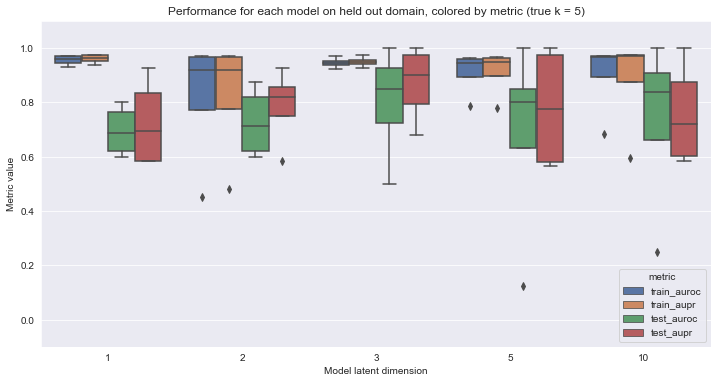

In [11]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(
    data=results_df.sort_values(by=['k_model'])
                   .sort_values(by=['metric'], ascending=False),
    x='k_model', y='value', hue='metric'
)
plt.title(
    'Performance for each model on held out domain, colored by metric (true k = {})'
    .format(k)
)
plt.xlabel('Model latent dimension')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

### Fit models with varying (fixed) k, on varying simulated k

Here, we'll vary both the simulation (true) k and the model k, to see if they correspond at all across a variety of different simulations. We can visualize the results in a heatmap, where we'd expect to see high values along the diagonal if the model is performing better for the "true" value of k.

In [12]:
results_df = pd.DataFrame()

for k_sim in tqdm(k_sim_range):
    xs, ys = simulate_csd(n_domains, n_per_domain, p, k_sim, 
                          corr_noise=True,
                          corr_top=corr_top,
                          diag=diag)
    domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])
    holdout_split = get_holdout_split(xs, ys, domains)
    (X_train,
     X_holdout,
     y_train,
     y_holdout,
     ds_train,
     ds_holdout) = holdout_split
    
    k_results_df = fit_csd_k_range(
        X_holdout, y_holdout, ds_holdout, k_model_range,
        stratify=True, train_data=(X_train, y_train, ds_train)
    )
    k_results_df['k_sim'] = k_sim
    results_df = pd.concat((results_df, k_results_df))
    
results_df.head()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,k_model,fold,metric,value,k_sim
0,1,0,train_auroc,0.623850,1
1,2,0,train_auroc,0.507403,1
2,3,0,train_auroc,0.533413,1
3,5,0,train_auroc,0.574630,1
4,10,0,train_auroc,0.669868,1


In [13]:
heatmap_metric = 'test_aupr'

heatmap_df = (results_df[results_df.metric == heatmap_metric]
    .groupby(['k_model', 'k_sim'])
    .mean()
    .drop(columns=['fold'])
    .reset_index()
    .pivot(index='k_sim', columns='k_model', values='value')
)

heatmap_df.head()

k_model,1,2,3,5,10
k_sim,,,,,
1,0.634325,0.756548,0.658333,0.703770,0.798611
2,0.958333,0.979167,0.945833,0.925000,0.958333
3,0.987500,1.000000,1.000000,0.987500,1.000000
5,0.636458,0.613194,0.623611,0.608681,0.620833
10,1.000000,1.000000,1.000000,1.000000,1.000000


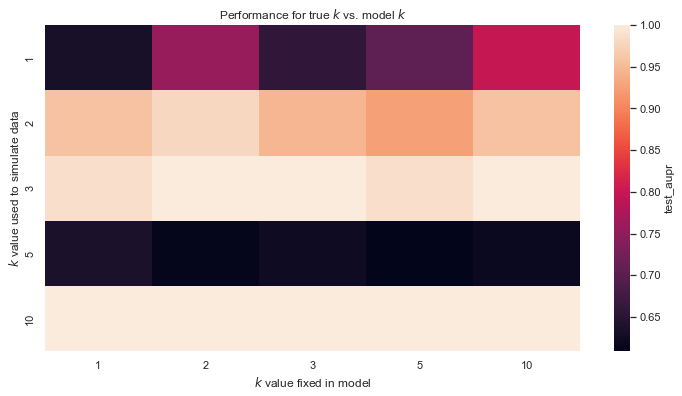

In [16]:
sns.set()

sns.heatmap(heatmap_df, cbar_kws={'label': heatmap_metric})
plt.title('Performance for true $k$ vs. model $k$')
plt.xlabel(r'$k$ value fixed in model')
plt.ylabel(r'$k$ value used to simulate data')

if output_plots:
    plt.savefig(
        output_plots_dir / 'n{}_p{}_ktop{}_corr{}_scale{}_heatmap.png'.format(
            n_domains, p, max(k_sim_range), corr_top, diag),
    dpi=200, bbox_inches='tight')

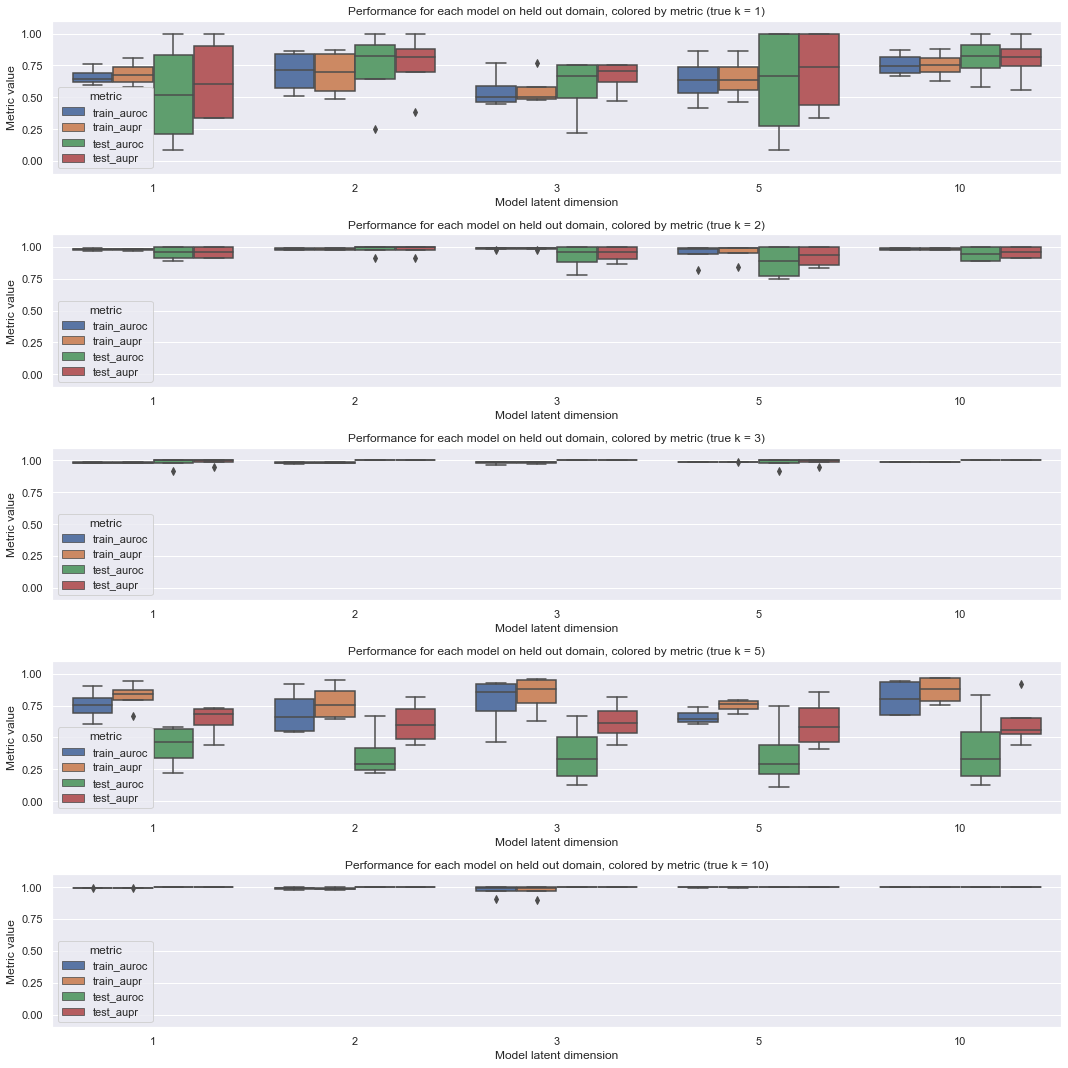

In [23]:
sns.set({'figure.figsize': (15, 15)})
fig, axarr = plt.subplots(5, 1)

for ix, k_sim in enumerate(k_sim_range):
    ax = axarr[ix]
    sns.boxplot(
        data=(results_df[results_df.k_sim == k_sim]
                .sort_values(by=['k_model'])
                .sort_values(by=['metric'], ascending=False)),
        x='k_model', y='value', hue='metric', ax=ax
    )
    ax.set_title(
        'Performance for each model on held out domain, colored by metric (true k = {})'
        .format(k_sim)
    )
    ax.set_xlabel('Model latent dimension')
    ax.set_ylabel('Metric value')
    ax.set_ylim(-0.1, 1.1)
    
plt.tight_layout()

if output_plots:
    plt.savefig(
        output_plots_dir / 'n{}_p{}_ktop{}_corr{}_scale{}_boxes.png'.format(
            n_domains, p, max(k_sim_range), corr_top, diag),
    dpi=200, bbox_inches='tight')